# Customer Lifetime Value Prediction (CLTV) using FLO DataSet

In [67]:
#pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 13.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flo-dataset/flo_data_20k.csv


## Dataset Review

In [5]:
df = pd.read_csv('/kaggle/input/flo-dataset/flo_data_20k.csv')

In [16]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

## Handling the Outliers

<Axes: xlabel='Variable', ylabel='Value'>

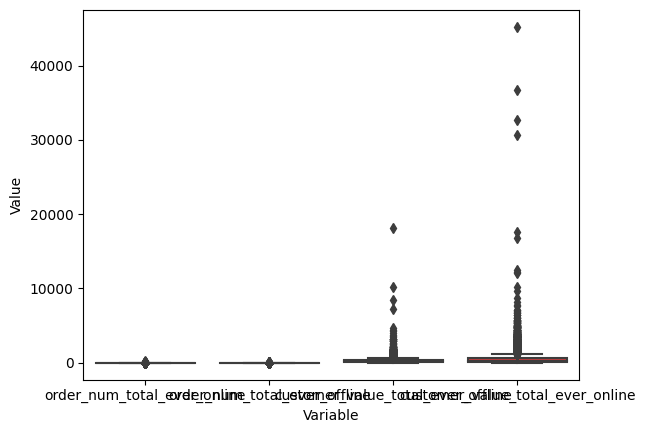

In [19]:
df_melted = pd.melt(df, value_vars=['order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online'], var_name='Variable', value_name='Value')
sns.boxplot(data=df_melted, x='Variable', y='Value')
plt.xticks(rotation = 30)
plt.show()

In [20]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [21]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [22]:
replace_with_thresholds(df, 'order_num_total_ever_online')
replace_with_thresholds(df, 'order_num_total_ever_offline')
replace_with_thresholds(df, 'customer_value_total_ever_offline')
replace_with_thresholds(df, 'customer_value_total_ever_online')

<Axes: xlabel='Variable', ylabel='Value'>

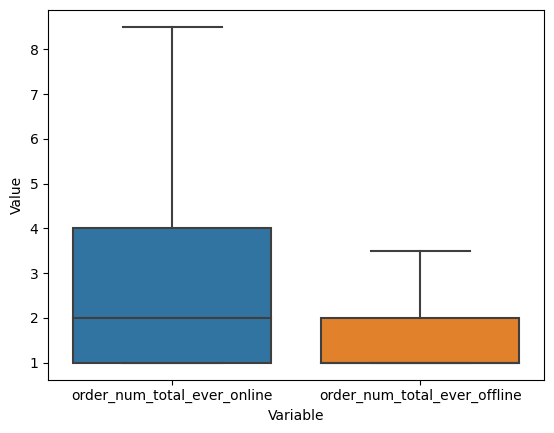

In [34]:
df_melted = pd.melt(df, value_vars=['order_num_total_ever_online', 'order_num_total_ever_offline'], var_name='Variable', value_name='Value')
sns.boxplot(data=df_melted, x='Variable', y='Value')


<Axes: xlabel='Variable', ylabel='Value'>

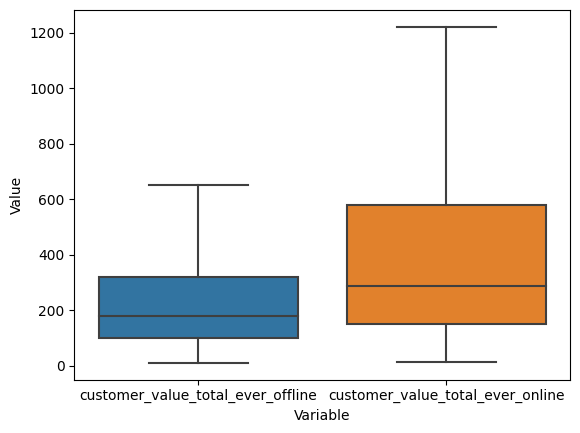

In [33]:
df_melted = pd.melt(df, value_vars=['customer_value_total_ever_offline', 'customer_value_total_ever_online'], var_name='Variable', value_name='Value')
sns.boxplot(data=df_melted, x='Variable', y='Value')

## Feature Engineering

In [38]:
df['customer_value_total_ever'] = df['customer_value_total_ever_offline'] + df['customer_value_total_ever_online'] 
df['order_num_total_ever'] = df['order_num_total_ever_offline'] + df['order_num_total_ever_online']

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [44]:
for i in df.columns:
    if 'date' in str(i):
        df[i] = pd.to_datetime(df[i])

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [62]:
focusdate = max(df['last_order_date']) + pd.Timedelta(days=2)

## Creating a CLTV DataFrame

In [63]:
df2 = pd.DataFrame(columns = ['customer_id', 'recency_cltv_weekly', 'T_weekly', 'frequency', 'monetary_cltv_avg'])
df2['customer_id'] = df['master_id']
df2['recency_cltv_weekly'] = (df['last_order_date'] - df['first_order_date']).dt.days / 7
df2["monetary_cltv_avg"] = (df["customer_value_total_ever"] / df["order_num_total_ever"])
df2["T_weekly"] = (focusdate - df['first_order_date']).dt.days / 7
df2["frequency"] = df["order_num_total_ever"]
df2 = df2[df2['recency_cltv_weekly'] > 0]

In [64]:
df2.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,30.571429,5.0,187.874000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,224.857143,10.5,131.533333
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,78.857143,5.0,117.064000
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,20.857143,2.0,60.985000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,95.428571,2.0,104.990000


## BG/NBD Model

In [72]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(df2['frequency'],
        df2['recency_cltv_weekly'],
        df2['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19920 subjects, a: 0.00, alpha: 111.99, b: 0.00, r: 4.76>

In [92]:
df2['exp_sales_3_months'] = bgf.predict(12,
            df2['frequency'],
            df2['recency_cltv_weekly'],
            df2['T_weekly']).sort_values(ascending=False)

In [93]:
df2['exp_sales_6_months'] = bgf.predict(24,
            df2['frequency'],
            df2['recency_cltv_weekly'],
            df2['T_weekly']).sort_values(ascending=False)

In [95]:
df2.sort_values(by="exp_sales_3_months", ascending=False).head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_3_months,exp_sales_6_months
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714286,13.000000,12.0,155.922500,1.609539,1.609539,3.219079
10876,ae149d98-9b6a-11eb-9c47-000d3a38a36f,6.142857,7.142857,9.0,161.334444,1.386479,1.386479,2.772958
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.142857,13.142857,9.5,185.270526,1.367947,1.367947,2.735894
6812,ecd961cc-89fd-11eb-bf0a-000d3a38a36f,7.142857,10.428571,9.0,96.233333,1.349265,1.349265,2.698529
19725,b42b0244-1e8d-11eb-9dc3-000d3a38a36f,27.857143,29.714286,11.0,122.242727,1.334998,1.334998,2.669996


In [100]:
df2['frequency'] = df2['frequency'].astype(int)

## Gamma-Gamma Model

In [109]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(df2['frequency'], df2['monetary_cltv_avg'])

df2["exp_average_value"] = ggf.conditional_expected_average_profit(df2['frequency'],
                                                                             df2['monetary_cltv_avg'])
df2.sort_values("expected_average_profit", ascending=False).head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_3_months,exp_sales_6_months,expected_average_profit,exp_average_value
12828,0c24fc44-2ac8-11ea-9d27-000d3a38a36f,68.000000,84.285714,2,765.550,NaN,0.413553,0.827107,819.688920,819.688920
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.000000,94.857143,2,710.560,NaN,0.392417,0.784834,760.966792,760.966792
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.285714,9.428571,2,650.215,NaN,0.668528,1.337056,696.526224,696.526224
794,7b96ae8a-f1c3-11e9-9346-000d3a38a36f,59.285714,84.571429,2,640.140,NaN,0.412952,0.825904,685.767441,685.767441
14819,875a74d6-d670-11e9-93bc-000d3a38a36f,81.571429,92.428571,2,635.560,NaN,0.397079,0.794159,680.876600,680.876600


In [110]:
df2['cltv'] = ggf.customer_lifetime_value(bgf,
                                   df2['frequency'],
                                   df2['recency_cltv_weekly'],
                                   df2['T_weekly'],
                                   df2['monetary_cltv_avg'],
                                   time=24,
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)
df2.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_3_months,exp_sales_6_months,expected_average_profit,exp_average_value,cltv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,30.571429,5,187.874000,NaN,0.821909,1.643817,193.613288,193.613288,1224.026926
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,224.857143,10,131.533333,NaN,0.543781,1.087562,133.640656,133.640656,540.668045
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,78.857143,5,117.064000,NaN,0.613954,1.227909,120.956178,120.956178,571.210882
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,20.857143,2,60.985000,NaN,0.611014,1.222027,67.305645,67.305645,316.325908
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,95.428571,2,104.990000,NaN,0.391336,0.782672,114.297230,114.297230,344.047029


In [111]:
df2.sort_values("cltv", ascending=False, ignore_index=True).head(20)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_3_months,exp_sales_6_months,expected_average_profit,exp_average_value,cltv
0,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.285714,9.428571,2,650.215000,NaN,0.668528,1.337056,696.526224,696.526224,3581.701186
1,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857143,7.857143,4,467.767500,NaN,0.877557,1.755115,484.175044,484.175044,3268.211645
2,635b5e0a-a686-11eb-a6d3-000d3a299ebf,2.000000,5.142857,3,447.110000,NaN,0.795441,1.590883,468.314715,468.314715,2865.354288
3,8897f4a8-c793-11ea-b753-000d3a38a36f,40.142857,45.714286,3,597.143333,NaN,0.590798,1.181595,624.986301,624.986301,2840.152104
4,f1f89712-84e5-11eb-8a3c-000d3a38a36f,7.285714,11.285714,2,522.450000,NaN,0.658456,1.316912,560.089913,560.089913,2836.723183
5,031b2954-6d28-11eb-99c4-000d3a38a36f,14.857143,15.571429,3,450.696667,NaN,0.730409,1.460818,472.060074,472.060074,2652.135294
6,b09765ae-29a1-11eb-b280-000d3a38a36f,1.571429,27.857143,2,552.810000,NaN,0.580429,1.160857,592.510423,592.510423,2645.313140
7,0c24fc44-2ac8-11ea-9d27-000d3a38a36f,68.000000,84.285714,2,765.550000,NaN,0.413553,0.827107,819.688920,819.688920,2607.431006
8,5ee23224-ad83-11ea-b736-000d3a38a36f,49.571429,50.428571,2,631.105000,NaN,0.499764,0.999527,676.119243,676.119243,2599.083266
9,251ced36-a2fb-11eb-a692-000d3a38a36f,2.000000,5.857143,2,449.960000,NaN,0.688789,1.377578,482.680074,482.680074,2557.277397


## Segmentation

In [116]:
df2["segment"] = pd.qcut(df2["cltv"], 4, labels=["S4", "S3", "S2", "S1"])

In [117]:
df2.groupby("segment").agg({"recency_cltv_weekly": "mean",
                            "frequency": "mean",
                            "monetary_cltv_avg": "mean"})

,recency_cltv_weekly,frequency,monetary_cltv_avg
segment,,,
S4,139.621457,3.715863,92.676009
S3,101.226391,4.311847,127.124717
S2,81.161102,4.598193,159.345912
S1,59.523264,4.835141,220.149370
